In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'hodaibrahim'
os.environ['KAGGLE_KEY'] = '22b10fa7b1865f7e7779cb5d58b02d9a'
!kaggle datasets download -d allen-institute-for-ai/CORD-19-research-challenge # api copied from kaggle

100% 3.00G/3.01G [00:34<00:00, 87.9MB/s]
100% 3.01G/3.01G [00:34<00:00, 93.6MB/s]


In [ ]:
os.listdir()
!unzip 'CORD-19-research-challenge.zip'

Streaming output truncated to the last 5000 lines.
  inflating: document_parses/pmc_json/PMC7235503.xml.json  
  inflating: document_parses/pmc_json/PMC7235504.xml.json  
  inflating: document_parses/pmc_json/PMC7235510.xml.json  
  inflating: document_parses/pmc_json/PMC7235511.xml.json  
  inflating: document_parses/pmc_json/PMC7235512.xml.json  
  inflating: document_parses/pmc_json/PMC7235513.xml.json  
  inflating: document_parses/pmc_json/PMC7235514.xml.json  
  inflating: document_parses/pmc_json/PMC7235515.xml.json  
  inflating: document_parses/pmc_json/PMC7235516.xml.json  
  inflating: document_parses/pmc_json/PMC7235517.xml.json  
  inflating: document_parses/pmc_json/PMC7235518.xml.json  
  inflating: document_parses/pmc_json/PMC7235519.xml.json  
  inflating: document_parses/pmc_json/PMC7235521.xml.json  
  inflating: document_parses/pmc_json/PMC7235522.xml.json  
  inflating: document_parses/pmc_json/PMC7235523.xml.json  
  inflating: document_parses/pmc_json/PMC7235524.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import requests
from bs4 import BeautifulSoup
import glob
import json
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from string import punctuation
from collections import defaultdict
ranking = defaultdict(int)
from heapq import nlargest
from nltk.probability import FreqDist
from nltk.corpus import stopwords
# from langdetect import detect  #detects what language is written
from nltk.collocations import BigramAssocMeasures
from nltk.collocations import BigramCollocationFinder
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize
import nltk


import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
!pip install word2number

  Created wheel for word2number: filename=word2number-1.1-cp36-none-any.whl size=5587 sha256=e8f8e9db40f16199f75482d31173030de1f576036a487216e931930ada195870
  Stored in directory: /root/.cache/pip/wheels/46/2f/53/5f5c1d275492f2fce1cdab9a9bb12d49286dead829a4078e0e
Successfully built word2number


In [4]:
import word2number
import spacy
from word2number import w2n
import en_core_web_sm
nlp = en_core_web_sm.load()

In [5]:
# Import data
#pd.set_option('max_colwidth',50)
metadata_path ='metadata.csv'
meta_df_org= pd.read_csv(metadata_path)
meta_df = meta_df_org.copy()
len(meta_df)

138794

In [6]:
meta_df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636.0,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967.0,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972.0,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871.0,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888.0,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [ ]:
all_json = glob.glob(f'**/*.json', recursive=True)
len(all_json)

120465

In [ ]:
all_data = []
# Reading the json as a dict
for file_path in all_json:
  with open(file_path) as json_data:
      data = json.load(json_data)
  try:
    try:
      abstract = ' '.join([text['text'] for text in data['abstract']])
    except:
      abstract = 'Not Provided'
      
    all_data.append([data['paper_id'], data['metadata']['title'],
      abstract,
      ' '.join([text['text'] for text in data['body_text']]) ])
    print(file_path)
  except Exception as e:
    print('Error in: ' + file_path + ' getting ' +str(e))
    continue

len(all_data)

In [ ]:
df = pd.DataFrame(all_data, columns=["paper_id", "title", "abstract", "body_text"])

In [ ]:
df.to_csv(r'json_df.csv', index = False)

In [7]:
# Import data
#pd.set_option('max_colwidth',50)
json_path ='json_df.csv'
json_df_org= pd.read_csv(json_path)
json_df = json_df_org.copy()
len(json_df)

120464

In [ ]:
# json_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [ ]:
draw_missing_data_table(json_df)

In [11]:
json_df.rename(columns={"paper_id": "sha"}, inplace=True)

In [12]:
json_df.head()

,sha,title,abstract,body_text
0,PMC7262329,Commentary on the management of total laryngec...,Not Provided,Coronavirus disease‐2019 (COVID‐19) was first ...
1,PMC7195848,Orthopaedic Surgical Selection and Inpatient P...,Not Provided,"On March 11, 2020, the World Health Organizati..."
2,PMC7147271,Be Prepared,Not Provided,None.
3,PMC4010719,In vitro RNA interference targeting the DNA po...,Not Provided,"Orf, also known as contagious ecthyma or cutan..."
4,PMC3618226,Alginic Acid-Coated Chitosan Nanoparticles Loa...,Not Provided,DNA-based vaccines provide protection against ...


In [13]:
mergedStuff = pd.merge(json_df, meta_df, on=['sha'], how='inner') #merged data by same sha
len(mergedStuff)

61659

In [14]:
len(mergedStuff[mergedStuff['body_text'].isna()])

0

In [15]:
mergedStuff.head()

,sha,title_x,abstract_x,body_text,cord_uid,source_x,title_y,doi,pmcid,pubmed_id,license,abstract_y,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,d1a63ffc7f247f2e825680e974760a8f73676d3c,NaN,Neutrophil gelatinase-associated lipocalin (NG...,Mechanical ventilation may induce and exacerba...,3e72pzui,PMC,Neutrophil gelatinase-associated lipocalin as ...,10.3892/mmr.2017.6442,PMC5436233,28393227.0,cc-by-nc-nd,Neutrophil gelatinase-associated lipocalin (NG...,2017-04-07,"Xiao, Rui; Chen, Rongchang",Mol Med Rep,NaN,NaN,NaN,document_parses/pdf_json/d1a63ffc7f247f2e82568...,document_parses/pmc_json/PMC5436233.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
1,d3b4cd3d7aa46f8795e95ed4734b69ae69870504,NaN,NaN,Pain management for laboratory rodents often r...,6i7irxbf,Medline; PMC,Lack of adverse effects during a target animal...,10.1038/laban.745,PMC7092016,26684956.0,no-cc,Extended-release buprenorphine is an effective...,2015-12-18,"Cowan, Alan; Sarabia-Estrada, Rachel; Wilkerso...",Lab Anim (NY),NaN,NaN,NaN,document_parses/pdf_json/d3b4cd3d7aa46f8795e95...,document_parses/pmc_json/PMC7092016.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/26684956/;...,21996678.0
2,18c823ca3451f8fe8d352b82a0602c18cafaf4fd,Efficacy of Zinc Against Common Cold Viruses: ...,Objective: To review the laboratory and clinic...,T he common cold is one of the most frequent i...,fob0os8u,Elsevier; Medline; PMC,Efficacy of Zinc Against Common Cold Viruses: ...,10.1331/1544-3191.44.5.594.hulisz,PMC7185598,15496046.0,no-cc,OBJECTIVE: To review the laboratory and clinic...,2015-12-23,"Hulisz, Darrell",J Am Pharm Assoc (2003),NaN,NaN,NaN,document_parses/pdf_json/18c823ca3451f8fe8d352...,document_parses/pmc_json/PMC7185598.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/15496046/;...,23889364.0
3,4370a15121a5e0bf0b204c903409735a2ce3479e,Is Sub-Saharan Africa prepared for COVID- 19?,Severe acute respiratory syndrome coronavirus ...,"To the Editor, A number of big cities in Asia ...",1mpzjgk1,Medline; PMC; WHO,Is Sub-Saharan Africa prepared for COVID-19?,10.1186/s41182-020-00206-x,PMC7146014,32288543.0,cc-by,Severe acute respiratory syndrome coronavirus ...,2020-04-10,"Nuwagira, Edwin; Muzoora, Conrad",Trop Med Health,NaN,#46453,NaN,document_parses/pdf_json/4370a15121a5e0bf0b204...,document_parses/pmc_json/PMC7146014.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/32288543/;...,215566818.0
4,059bff0ccd4da6abda682e171a8c35987b6482ea,Original Article,Human serum albumin (HSA) Niclosamide SterneVo...,Niclosamide (5-chloro-N-(2-chloro-4-nitropheny...,mmafv2b5,Elsevier; Medline; PMC,Binding interactions of niclosamide with serum...,10.1016/j.jfda.2014.03.004,PMC7129377,28911473.0,no-cc,A study of the binding of niclosamide (NC) to ...,2014-05-06,"Maltas, Esra",J Food Drug Anal,NaN,NaN,NaN,document_parses/pdf_json/059bff0ccd4da6abda682...,document_parses/pmc_json/PMC7129377.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/28911473/;...,13086176.0


In [16]:
mergedStuff[['abstract_x','abstract_y']].head()

,abstract_x,abstract_y
0,Neutrophil gelatinase-associated lipocalin (NG...,Neutrophil gelatinase-associated lipocalin (NG...
1,NaN,Extended-release buprenorphine is an effective...
2,Objective: To review the laboratory and clinic...,OBJECTIVE: To review the laboratory and clinic...
3,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus ...
4,Human serum albumin (HSA) Niclosamide SterneVo...,A study of the binding of niclosamide (NC) to ...


In [17]:
mergedStuff[['abstract_x','abstract_y']].head().style.set_properties(**{'text-align': "justify"})

,abstract_x,abstract_y
0,"Neutrophil gelatinase-associated lipocalin (NGAL) is a 25-kDa protein of the lipocalin superfamily and its presence was initially observed in activated neutrophils. It has previously been demonstrated that the expression of NGAL is markedly increased in stimulated epithelia, and is important in the innate immunological response to various pathophysiological conditions, including infection, cancer, inflammation and kidney injury. The present study constructed a ventilator-associated lung injury model in mice. NGAL mRNA and protein expression levels in lung tissue were detected using reverse transcription-quantitative polymerase chain reaction and western blotting, respectively. In addition, NGAL protein levels in bronchoalveolar lavage fluid and serum were measured via western blotting. The results of the present study suggested that NGAL expression increased under all mechanical ventilation treatments. The increase was most prominent in the high peak inflation pressure and high-volume mechanical ventilation groups, where there was the greatest extent of lung injury. In addition, NGAL expression increased in a time-dependent manner under high-volume mechanical ventilation, consistent with the degree of lung injury. These findings suggested that NGAL may serve as a potential novel biomarker in ventilator-associated lung injury.","Neutrophil gelatinase-associated lipocalin (NGAL) is a 25-kDa protein of the lipocalin superfamily and its presence was initially observed in activated neutrophils. It has previously been demonstrated that the expression of NGAL is markedly increased in stimulated epithelia, and is important in the innate immunological response to various pathophysiological conditions, including infection, cancer, inflammation and kidney injury. The present study constructed a ventilator-associated lung injury model in mice. NGAL mRNA and protein expression levels in lung tissue were detected using reverse transcription-quantitative polymerase chain reaction and western blotting, respectively. In addition, NGAL protein levels in bronchoalveolar lavage fluid and serum were measured via western blotting. The results of the present study suggested that NGAL expression increased under all mechanical ventilation treatments. The increase was most prominent in the high peak inflation pressure and high-volume mechanical ventilation groups, where there was the greatest extent of lung injury. In addition, NGAL expression increased in a time-dependent manner under high-volume mechanical ventilation, consistent with the degree of lung injury. These findings suggested that NGAL may serve as a potential novel biomarker in ventilator-associated lung injury."
1,nan,"Extended-release buprenorphine is an effective analgesic in laboratory animals, and its safety has been established in mice but not in rats. The authors used a target animal safety trial to evaluate the safety of extended-release buprenorphine in rats. Fischer 344 rats received post-surgical subcutaneous injections of 1.3 mg, 3.9 mg or 6.5 mg buprenorphine per kg body weight (two times, six times or ten times the intended dose, respectively), and their body weight, clinical signs and symptoms, clinical pathology and histopathology were monitored for 4 d. Body weight was not significantly different in rats that received buprenorphine compared with control rats. Signs of nausea-related behavior were observed in 25% of the rats treated with buprenorphine. Clinical pathology results for all rats were normal, and gross and microscopic histopathology examinations identified no substantial abnormalities, suggesting that this behavior was of minor consequence. Other adverse events previously reported to occur with opiate therapy, including weight loss and dermal lesions at drug injection sites, were not observed in this study. The results of this study show that post-surgical administration of an extended-release buprenorphine product is safe in Fischer 34

In [18]:
mergedStuff['word_count_json'] = mergedStuff['abstract_x'].apply(lambda x: len(str(x).split(" ")))
mergedStuff['word_count_meta'] = mergedStuff['abstract_y'].apply(lambda x: len(str(x).split(" ")))

In [19]:
mergedStuff[['word_count_json','word_count_meta']].head(15)

,word_count_json,word_count_meta
0,181,181
1,1,207
2,294,292
3,14,129
4,154,136
5,299,299
6,274,282
7,240,104
8,1,353
9,276,278


In [20]:
mergedStuff.loc[7]['abstract_y']

'In this study feline (FECV and FIPV) and canine (CCoV) coronavirus entry into and release from polarized porcine epithelial LLC-PK1 cells, stably expressing the recombinant feline aminopeptidase-N cDNA, were investigated. Virus entry appeared to occur preferentially through the apical membrane, similar to the entry of the related porcine coronavirus transmissible gastroenteritis virus (TGEV) into these cells. However, whereas TGEV is released apically, feline and canine coronaviruses were found to be released from the basolateral side of the epithelial cells. These observations indicate that local infections as caused by TGEV, FECV and CCoV do not strictly correlate with apical release, as suggested by earlier work.'

In [21]:
mergedStuff.loc[7]['abstract_x']

'In this study feline (FECV and FIPV) and canine (CCoV) coronavirus entry into and release from polarized porcine epithelial LLC-PK1 cells, stably expressing the recombinant feline aminopeptidase-N cDNA, were investigated. Virus entry appeared to occur preferentially through the apical membrane, similar to the entry of the related porcine coronavirus transmissible gastroenteritis virus (TGEV) into these cells. However, whereas TGEV is released apically, feline and canine coronaviruses were found to be released from the basolateral side of the epithelial cells. These observations indicate that local infections as caused by TGEV, FECV and CCoV do not strictly correlate with apical release, as suggested by earlier work. * Coronaviruses have been shown to infect humans and animals. The viruses have a narrow host range and the consequences of infection range from subclinical to lethal, symptoms including respiratory and enteric disease (most commonly) as well as hepatitis, peritonitis and e

In [22]:
def get_longer_text(clomn_x, column_y):
    return clomn_x if len(str(clomn_x).strip().split(" ")) > len(str(column_y).strip().split(" ")) else column_y
    
mergedStuff['abstract'] = mergedStuff.apply(lambda row: get_longer_text(row['abstract_x'], row['abstract_y']), axis = 1)

In [23]:
mergedStuff['word_count_abstract'] = mergedStuff['abstract'].apply(lambda x: len(str(x).split(" ")))

In [24]:
mergedStuff['word_count_abstract'].head(15)

0      181
1      207
2      294
3      129
4      154
5      299
6      282
7      240
8      353
9      278
10     225
11     181
12    5316
13     241
14     214
Name: word_count_abstract, dtype: int64

In [25]:
mergedStuff.drop(['abstract_x','abstract_y', 'word_count_json', 'word_count_meta'], axis=1, inplace=True)

In [26]:
mergedStuff['title_count_json'] = mergedStuff['title_x'].apply(lambda x: len(str(x).split(" ")))
mergedStuff['title_count_meta'] = mergedStuff['title_y'].apply(lambda x: len(str(x).split(" ")))

In [27]:
mergedStuff[['title_count_json','title_count_meta']].head(15)

,title_count_json,title_count_meta
0,1,12
1,1,17
2,14,9
3,7,6
4,2,7
5,14,8
6,14,14
7,23,21
8,1,14
9,7,7


In [28]:

mergedStuff['title'] = mergedStuff.apply(lambda row: get_longer_text(row['title_x'], row['title_y']), axis = 1)

In [29]:
mergedStuff['word_count_title'] = mergedStuff['title'].apply(lambda x: len(str(x).split(" ")))

In [30]:
mergedStuff.drop(['title_x','title_y', 'title_count_json', 'title_count_meta'], axis=1, inplace=True)

In [31]:
mergedStuff['word_count_title'].head(15)

0      12
1      17
2      14
3       7
4       7
5      14
6      14
7      23
8      14
9       7
10      8
11      4
12    382
13     11
14     16
Name: word_count_title, dtype: int64

In [32]:
# mergedStuff.drop(['Microsoft Academic Paper ID','WHO #Covidence'], axis=1, inplace=True)

In [33]:
mergedStuff = mergedStuff[['sha', 'body_text', 'abstract', 'word_count_abstract' ,'title', 'word_count_title', 'url','source_x','doi','license','publish_time','authors','journal']]

In [34]:
mergedStuff.head(5)

,sha,body_text,abstract,word_count_abstract,title,word_count_title,url,source_x,doi,license,publish_time,authors,journal
0,d1a63ffc7f247f2e825680e974760a8f73676d3c,Mechanical ventilation may induce and exacerba...,Neutrophil gelatinase-associated lipocalin (NG...,181,Neutrophil gelatinase-associated lipocalin as ...,12,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,PMC,10.3892/mmr.2017.6442,cc-by-nc-nd,2017-04-07,"Xiao, Rui; Chen, Rongchang",Mol Med Rep
1,d3b4cd3d7aa46f8795e95ed4734b69ae69870504,Pain management for laboratory rodents often r...,Extended-release buprenorphine is an effective...,207,Lack of adverse effects during a target animal...,17,https://www.ncbi.nlm.nih.gov/pubmed/26684956/;...,Medline; PMC,10.1038/laban.745,no-cc,2015-12-18,"Cowan, Alan; Sarabia-Estrada, Rachel; Wilkerso...",Lab Anim (NY)
2,18c823ca3451f8fe8d352b82a0602c18cafaf4fd,T he common cold is one of the most frequent i...,Objective: To review the laboratory and clinic...,294,Efficacy of Zinc Against Common Cold Viruses: ...,14,https://www.ncbi.nlm.nih.gov/pubmed/15496046/;...,Elsevier; Medline; PMC,10.1331/1544-3191.44.5.594.hulisz,no-cc,2015-12-23,"Hulisz, Darrell",J Am Pharm Assoc (2003)
3,4370a15121a5e0bf0b204c903409735a2ce3479e,"To the Editor, A number of big cities in Asia ...",Severe acute respiratory syndrome coronavirus ...,129,Is Sub-Saharan Africa prepared for COVID- 19?,7,https://www.ncbi.nlm.nih.gov/pubmed/32288543/;...,Medline; PMC; WHO,10.1186/s41182-020-00206-x,cc-by,2020-04-10,"Nuwagira, Edwin; Muzoora, Conrad",Trop Med Health
4,059bff0ccd4da6abda682e171a8c35987b6482ea,Niclosamide (5-chloro-N-(2-chloro-4-nitropheny...,Human serum albumin (HSA) Niclosamide SterneVo...,154,Binding interactions of niclosamide with serum...,7,https://www.ncbi.nlm.nih.gov/pubmed/28911473/;...,Elsevier; Medline; PMC,10.1016/j.jfda.2014.03.004,no-cc,2014-05-06,"Maltas, Esra",J Food Drug Anal


In [35]:
dp = mergedStuff[mergedStuff.duplicated(['body_text'])] #len of duplicated sha in mergedStuff
len(dp)

161

In [36]:
mergedStuff[mergedStuff['body_text'].str.contains("The COVID-19 pandemic has resulted in a proliferation of clinical trials that are designed to slow the spread of severe acute respiratory")]['abstract']

5552     Abstract The COVID-19 pandemic has resulted in...
44739    Abstract The COVID-19 pandemic has resulted in...
Name: abstract, dtype: object

In [37]:
mergedStuff.drop_duplicates(subset =["body_text"], inplace = True,keep='first') 

In [38]:
len(mergedStuff)

61498

In [39]:
nonMergedSJsontuff = json_df[(~json_df.sha.isin(mergedStuff.sha))]  #data with diff sha in json file (non merged)
len(nonMergedSJsontuff)

58966

In [40]:
dpj = nonMergedSJsontuff[nonMergedSJsontuff.duplicated(['body_text'])] #len of duplicated sha in mergedStuff
len(dpj)

1707

In [41]:
nonMergedSJsontuff.drop_duplicates(subset =["body_text"], inplace = True,keep='first') 

In [42]:
len(nonMergedSJsontuff)

57259

In [1]:
nonMergedSJsontuff["body_text"] = nonMergedSJsontuff["body_text"].str.lower()

NameError: ignored

In [ ]:
nonMergedSJsontuff = nonMergedSJsontuff[nonMergedSJsontuff["body_text"].str.contains("covid|cov-2|cov2|ncov", na=False)]

In [ ]:
len(nonMergedSJsontuff)

In [ ]:
# 38178+46366

In [ ]:
mergedStuff = pd.concat([mergedStuff,nonMergedSJsontuff], axis=0, ignore_index=True)

In [ ]:
len(mergedStuff)

In [ ]:
dpj = mergedStuff[mergedStuff.duplicated(['body_text'])] #len of duplicated sha in mergedStuff
len(dpj)

In [ ]:
nonMergedMetaStuff = meta_df[(~meta_df.sha.isin(mergedStuff.sha))]  #data with diff sha in detadata file(non merged)
len(nonMergedMetaStuff)

In [3]:
dpm = nonMergedMetaStuff[nonMergedMetaStuff.duplicated(['abstract'])] #len of duplicated sha in mergedStuff
len(dpm)

NameError: ignored

In [ ]:
mergedStuff = pd.concat([mergedStuff,nonMergedMetaStuff], axis=0, ignore_index=True)

In [ ]:
len(mergedStuff)

In [ ]:
draw_missing_data_table(nonMergedMetaStuff)

In [4]:
mergedStuff['bt_count'] = mergedStuff['body_text'].apply(lambda x: len(str(x).split(" ")))

NameError: ignored

In [ ]:
# del mergedStuff['bt_count_json']

In [ ]:
mergedStuff.head()

In [ ]:
mergedStuff['Year'] = pd.to_datetime(mergedStuff['publish_time']).dt.year

In [ ]:
mergedStuff.info()

In [ ]:
mergedStuff = mergedStuff[mergedStuff['Year'] == 2020]

In [ ]:
len(mergedStuff)

In [ ]:
len(choosen[choosen['body_text'].notna()])

In [ ]:
len(text)

In [ ]:
!pip install msgpack==0.5.6 spacy==2.0.13 https://github.com/huggingface/neuralcoref-models/releases/download/en_coref_md-3.0.0/en_coref_md-3.0.0.tar.gz


In [ ]:
mergedStuff['bt_count_word'] = mergedStuff['body_text'].apply(lambda x: len(str(x).split(" ")))


In [ ]:
choosen = mergedStuff[mergedStuff['bt_count_word'] > 30]

In [ ]:
len(choosen)

13741

In [ ]:
choosen.loc[choosen['body_text'].notna()].describe()

,word_count_abstract,word_count_title,pubmed_id,mag_id,s2_id,bt_count,Year,bt_count_word
count,13741.000000,13741.000000,0.0,0.0,0.0,13741.000000,13741.0,13741.000000
mean,175.537588,15.701841,NaN,NaN,NaN,2660.484026,2020.0,2660.484026
std,191.277707,9.556838,NaN,NaN,NaN,2761.216361,0.0,2761.216361
min,1.000000,1.000000,NaN,NaN,NaN,31.000000,2020.0,31.000000
25%,38.000000,10.000000,NaN,NaN,NaN,979.000000,2020.0,979.000000
50%,163.000000,14.000000,NaN,NaN,NaN,2050.000000,2020.0,2050.000000
75%,250.000000,19.000000,NaN,NaN,NaN,3549.000000,2020.0,3549.000000
max,6326.000000,241.000000,NaN,NaN,NaN,91469.000000,2020.0,91469.000000


In [ ]:
mergedStuff['body_text'].head()

7     Since December 2019, cases of unexplained pneu...
16    IDentif.AI showed hydroxychloroquine and azith...
18    LNo!new!ART!enrolments! LNo!new!VMMC! L(No!PrE...
20    conduct and participate in sporting events. Co...
29    In 2015 and 2016, large outbreaks of Zika viru...
Name: body_text, dtype: object

In [ ]:
!pip install nltk

In [ ]:
abs_by_bt = mergedStuff.loc[(mergedStuff['abstract'].isna())]
len(abs_by_bt)

4197

In [ ]:
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def summarize(index, text, n):
    sents = sent_tokenize(text)
    if len(sents) < 6:
        n = len(sents)
    
    assert n <= len(sents)
    word_sent = word_tokenize(text.lower())
    _stopwords = set(stopwords.words('english') + list(punctuation))
    _stopwords.update(['.', ',', 'the', 'another', 'is', 'dear', 'also', 'may', 'of', 'a', 'are', 'From'])
    
    word_sent=[word for word in word_sent if word not in _stopwords]
    freq = FreqDist(word_sent)
    
    
    ranking = defaultdict(int)
    
    for i,sent in enumerate(sents):
        for w in word_tokenize(sent.lower()):
            if w in freq:
                ranking[i] += freq[w]
             
        
    sents_idx = nlargest(n, ranking, key=ranking.get)
    abstract = ' '.join([sents[j] for j in sorted(sents_idx)])
    mergedStuff.at[index, 'abstract'] = abstract
    return

In [ ]:
res = abs_by_bt.apply(lambda row: summarize(row.name, str(row['body_text']), 6) ,axis=1)

In [ ]:
mergedStuff.to_csv(r'merged_stuff_after_summarizing.csv', index = False)

In [ ]:
mergedStuff_path ='merged_stuff_after_summarizing.csv'
mergedStuff_org = pd.read_csv(mergedStuff_path)
mergedStuff = mergedStuff_org.copy()

In [ ]:
mergedStuff['body_text'].head()

0    incluaient des patients hospitalisés pour pneu...
1    On 8 February 2020 an alarming report in the C...
2    In the current SARS-CoV-2 pandemic (COVID-19),...
3    Authorities in most countries have imposed res...
4    The novel coronavirus disease that was first r...
Name: body_text, dtype: object

In [ ]:
token_pattern = '(?u)\\b[a-zA-Z][a-zA-Z]+'
token_expression = re.compile(token_pattern)

In [ ]:
mergedStuff['body_text'] = mergedStuff['body_text'].apply(lambda description: " ".join(token_expression.findall(str(description))))

In [ ]:
# from google.colab import files
# files.download('/content/outfile')

In [ ]:
items = {'II'}
def remove_str_nums(text):
  try:
      doc = nlp(text)
      res = []
      for token in doc:
          if token.pos_ == 'NUM':
              try:
                  res.append(w2n.word_to_num(token.text))
                  print(token,'-------------------',w2n.word_to_num(token.text))
              except Exception as e:
                  res.append(token.text)
                  items.add(token.text)
                  print("ُError in: " + token.text + "-------------------" + str(e))
          else:
              res.append(token.text)
      text = ' '.join([str(elem) for elem in res]) 
  except Exception as e:
      print(e)
    
  return text

In [ ]:
mergedStuff['body_text'] = mergedStuff['body_text'].apply(lambda description: remove_str_nums(description))

In [ ]:
mergedStuff.to_csv(r'convertNums.csv', index = False)

In [ ]:
with open('your_file.txt', 'w') as f:
    for item in items:
        f.write("%s\n" % item)

In [ ]:
with open("useless.txt") as file_in:
    useless = []
    for line in file_in:
        useless.append(line[:-1])

In [ ]:
len(useless)

In [ ]:
mergedStuff['body_text'] = mergedStuff['body_text'].apply(lambda x: clean_text(str(x)))

In [ ]:
useless = ['doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
        'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
         'al.', 'Elsevier', 'PMC', 'CZI', 'www',"fig","figure", "et", "al", "table",  
        "data", "analysis", "analyze", "study",  
        "method", "result", "conclusion", "author",  
        "find", "found", "show", "perform",  
        "demonstrate", "evaluate", "discuss", "google", "scholar",   
        "pubmed",  "web", "science", "crossref", "supplementary", "A" ,"this" ,"that",'III','II']

useless = [word.lower() for word in useless]

In [ ]:
stop_words = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
stop_words.update(useless)

stop_words

{'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'ain',
 'al',
 'al.',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst',
 'amount',
 'an',
 'analysis',
 'analyze',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'aren',
 "aren't",
 'around',
 'as',
 'at',
 'author',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'bill',
 'biorxiv',
 'both',
 'bottom',
 'but',
 'by',
 'call',
 'can',
 'cannot',
 'cant',
 'co',
 'con',
 'conclusion',
 'copyright',
 'could',
 'couldn',
 "couldn't",
 'couldnt',
 'crossref',
 'cry',
 'czi',
 'd',
 'data',
 'de',
 'demonstrate',
 'describe',
 'detail',
 'did',
 'didn',
 "didn't",
 'discuss',
 'do',
 'does',
 'doesn',
 "doesn't",
 'doi',
 'doing',
 'don',
 "don't"

In [ ]:
mergedStuff['body_text'] = mergedStuff['body_text'].apply(lambda x: " ".join(x for x in word_tokenize(str(x).lower()) if x not in stop_words))

In [ ]:
mergedStuff['body_text'].head()

0    incluaient des patients hospitalis pour pneumo...
1    february alarming report china news weekly eme...
2    current sars cov pandemic covid children sever...
3    authorities countries imposed restrictions soc...
4    novel coronavirus disease reported wuhan china...
Name: body_text, dtype: object

In [ ]:
stemmer = nltk.stem.snowball.SnowballStemmer('english')
stems = stemmer.stem("antibodi")
stems

'antibodi'

In [ ]:
mergedStuff['body_text'] = mergedStuff['body_text'].apply(lambda x: " ".join([ stemmer.stem(word) for word in x.split()]))

In [ ]:
mergedStuff['body_text'].head()

0    incluaient des patient hospitali pour pneumoni...
1    februari alarm report china news week emerg in...
2    current sar cov pandem covid children sever af...
3    author countri impos restrict social contact r...
4    novel coronavirus diseas report wuhan china de...
Name: body_text, dtype: object

In [ ]:
def clean_text_round4(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('\n', ' ', text)
    text = re.sub('\t', ' ', text)
    text = re.sub('\ .{0,2}\ ',' ', text)
    return str(text)

In [ ]:
mergedStuff['body_text'] = mergedStuff['body_text'].apply(lambda x: clean_text_round4(str(x)))

In [ ]:
mergedStuff.to_csv(r'cleaned.csv', index = False)

In [ ]:
mergedStuff_path = 'cleaned.csv'
mergedStuff_org = pd.read_csv(mergedStuff_path)
mergedStuff = mergedStuff_org.copy()

In [ ]:
text = list(choosen['body_text'])
# Import the PhraseMatcher and initialize it
from spacy.matcher import PhraseMatcher
matcher = PhraseMatcher(nlp.vocab)

# Create pattern Doc objects and add them to the matcher
# This is the faster version of: [nlp(country) for country in COUNTRIES]
# patterns = list(nlp.pipe(COUNTRIES))
# matcher.add('COUNTRY', None, *patterns)
def func(test):
  # transmission, incubation, and environmental stability
  doc = nlp(test)
  # Call the matcher on the test document and print the result
  pattern1 = [{'LEMMA': 'transitive'}]
  pattern2 = [{'LEMMA': 'incubation'}]
  pattern3 = [{'LEMMA': 'environmental'},{'LEMMA': 'stability'}]

  # Add the pattern to the matcher and apply the matcher to the doc
  matcher.add('pattern1', None, pattern1)
  matches = matcher(doc)
  print('Total matches found:', len(matches))

  # Iterate over the matches and print the span text
  for match_id, start, end in matches:
      print('Match found:', doc[start:end].text)
      print(test)



for test in text:
  func(test)


In [ ]:
  # Add the pattern to the matcher and apply the matcher to the doc
  matcher.add('pattern2', None, pattern1)
  matches = matcher(doc)
  print('Total matches found:', len(matches))

  # Iterate over the matches and print the span text
  for match_id, start, end in matches:
      print('Match found:', doc[start:end].text)



for test in text:
  func(test)

In [ ]:
  # Add the pattern to the matcher and apply the matcher to the doc
  matcher.add('pattern3', None, pattern1)
  matches = matcher(doc)
  print('Total matches found:', len(matches))

  # Iterate over the matches and print the span text
  for match_id, start, end in matches:
      print('Match found:', doc[start:end].text)



for test in text:
  func(test)

In [ ]:
mergedStuff['body_text'].head()

In [ ]:
import nltk
nltk.download('all')

In [ ]:
with open("used.txt") as file_in:
    used = []
    for line in file_in:
        used.append(line[:-1])

In [ ]:
used

In [ ]:
sent = "Io andiamo to nCOV the beach with my amico."
words = nltk.corpus.words.words()
used = [x.lower() for x in used]
words = words + used
words = set(words)
set(words)
for word in nltk.wordpunct_tokenize(sent):
   if word.lower() in words or not word.isalpha():
     print(word)

In [ ]:
set(nltk.corpus.words.words())

In [ ]:
""""
import nltk

words = nltk.corpus.words.words()
used = [x.lower() for x in used]
words = words + used
words = set(words)
# 
mergedStuff['body_text'] = mergedStuff['body_text'].apply(lambda x:" ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()))





# 'Io to the beach with my'
""""

In [ ]:
mergedStuff = mergedStuff[mergedStuff['body_text'].notna()]

In [ ]:
len(mergedStuff[mergedStuff['body_text'].isna()])
dump = mergedStuff

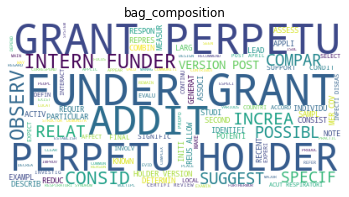

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def wordcloud(dataframe):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",stopwords=stopwords).generate(" ".join([i for i in dataframe.str.upper()]))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("bag_composition")

wordcloud(mergedStuff['body_text'])

In [ ]:
freq = pd.Series(' '.join(mergedStuff['body_text']).split()).value_counts()[:50]

In [ ]:
freq.index

In [ ]:
stop_words = ["fig","figure","table", 'use','licens','group','provid',
        "data", "analysis", "analyze", "study",  'model','includ','follow','copyright','display',
        "method", "result", "conclusion", "author",  'day','base','level','medrxiv',
        "find", "found", "show", "perform",  'preprint','differ','popul','high',
        "demonstrate", "evaluate", "discuss", "google", "scholar",'doi',
        "pubmed",  "web", "science", "crossref", "supplementary","this" ,"that",
        'use', 'test', 'al', 'covid', 'data', 'virus', 'time', 'model',
       'infect', 'result', 'differ', 'base', 'number', 'case', 'detect',
       'high', 'effect', 'patient', 'posit', 'perform', 'method', 'fig',
       'group', 'report', 'follow', 'rate', 'set', 'inform', 'sar', 'develop',
       'process', 'level', 'network', 'control', 'import', 'human', 'work',
       'present', 'research', 'like', 'similar', 'risk', 'new', 'viral',
       'region', 'chang', 'function', 'product', 'avail', 'need', 'limit',
       'non', 'approach', 'indic', 'day', 'type', 'learn', 'respect', 'shown',
       'train', 'year', 'given', 'clinic', 'obtain', 'user', 'contain',
       'health', 'term', 'low', 'higher', 'mean', 'factor', 'pathogen',
       'genom', 'state', 'collect', 'direct', 'size', 'predict', 'public',
       'total', 'section', 'protein', 'order', 'form', 'area', 'previous',
       'current', 'point', 'water', 'gene', 'general', 'contact', 'probabl',
       'social', 'author', 'target', 'treatment', 'environ', 'cell']


In [ ]:
mergedStuff['body_text'] = mergedStuff['body_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [ ]:
text = mergedStuff
mergedStuff = mergedStuff[mergedStuff['body_text'].notna()]

In [ ]:
""""
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')
""""


In [ ]:
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1, 3), min_df=500, max_df = .55)
description_vectors = vectorizer.fit_transform(mergedStuff['body_text'])
print(description_vectors.shape)

feature_names = vectorizer.get_feature_names()
feature_names[:50]

In [ ]:
clusterer = KMeans(n_clusters=10, random_state=1)
mergedStuff['Cluster Index'] =clusterer.fit_predict(description_vectors)
cluster_indices = pd.Series(
    clusterer.fit_predict(description_vectors), 
    name='Cluster Index'
)

In [ ]:
mergedStuff[['body_text','Cluster Index']]

,body_text,Cluster Index
0,incluaient des hospitali pour pneumoni provoqu...,0
1,februari alarm china news week emerg inpati ps...,8
2,cov pandem children sever affect adult seri ch...,9
3,countri impos restrict rsc various ban outsid ...,3
4,novel coronavirus diseas wuhan china decemb qu...,3
...,...,...
10332,mainland china januari recent throat swab take...,1
10333,bat respons zoonot transmiss major diseas outb...,6
10334,circul china countri territori epidem confirm ...,2
10335,coronavirus diseas newli recogn ill caus sever...,4


In [ ]:
from nltk.probability import FreqDist

In [ ]:
clus0 = mergedStuff.loc[mergedStuff['Cluster Index'] == 0]
freq_abs0 = pd.Series(' '.join(clus0['body_text']).split()).value_counts()[:100]
freq_abs0.index

Index(['sampl', 'sequenc', 'cov', 'rna', 'valu', 'structur', 'imag', 'specif',
       'diseas', 'increas', 'observ', 'relat', 'compar', 'pcr', 'identifi',
       'addit', 'measur', 'individu', 'strain', 'studi', 'signific', 'generat',
       'assay', 'consid', 'dataset', 'coronavirus', 'negat', 'activ', 'featur',
       'acid', 'requir', 'interact', 'select', 'concentr', 'dna', 'repres',
       'associ', 'potenti', 'bind', 'estim', 'propos', 'determin', 'larg',
       'speci', 'singl', 'host', 'possibl', 'algorithm', 'step', 'condit',
       'caus', 'isol', 'cluster', 'sensit', 'class', 'distribut', 'allow',
       'suggest', 'temperatur', 'exampl', 'design', 'respiratori', 'site',
       'extract', 'holder', 'vaccin', 'complex', 'mutat', 'rang', 'reaction',
       'paramet', 'effici', 'read', 'comput', 'reduc', 'refer', 'express',
       'describ', 'appli', 'epitop', 'calcul', 'initi', 'score', 'consist',
       'improv', 'intern', 'recent', 'locat', 'surfac', 'respons', 'averag',
   

In [ ]:
clus1 = mergedStuff.loc[mergedStuff['Cluster Index'] == 1]
freq_abs1 = pd.Series(' '.join(clus1['body_text']).split()).value_counts()[:100]
freq_abs1.index

Index(['funder', 'post', 'version', 'holder', 'grant', 'perpetu', 'april',
       'intern', 'review', 'certifi', 'estim', 'death', 'countri', 'diseas',
       'cov', 'individu', 'hospit', 'allow', 'age', 'valu', 'sever', 'measur',
       'epidem', 'increas', 'sampl', 'studi', 'symptom', 'reus', 'observ',
       'paramet', 'signific', 'relat', 'peopl', 'confirm', 'pandem',
       'transmiss', 'period', 'compar', 'mortal', 'specif', 'spread', 'consid',
       'march', 'outbreak', 'care', 'associ', 'distanc', 'assum', 'addit',
       'distribut', 'outcom', 'infecti', 'variabl', 'polici', 'reduc', 'week',
       'coronavirus', 'identifi', 'lower', 'suggest', 'possibl', 'daili',
       'requir', 'china', 'averag', 'respiratori', 'activ', 'isol', 'respons',
       'icu', 'initi', 'repres', 'larg', 'negat', 'simul', 'condit',
       'strategi', 'rang', 'potenti', 'intervent', 'proport', 'statist',
       'expect', 'scenario', 'communiti', 'peak', 'earli', 'assess', 'date',
       'caus', 'cit

In [ ]:
clus2 = mergedStuff.loc[mergedStuff['Cluster Index'] == 2]
freq_abs2 = pd.Series(' '.join(clus2['body_text']).split()).value_counts()[:100]
freq_abs2.index

Index(['care', 'hospit', 'mask', 'protect', 'diseas', 'procedur', 'pandem',
       'medic', 'staff', 'recommend', 'requir', 'room', 'surgeri',
       'respiratori', 'cov', 'ppe', 'surgic', 'manag', 'emerg', 'transmiss',
       'healthcar', 'increas', 'oper', 'ventil', 'person', 'consid', 'cancer',
       'face', 'reduc', 'prevent', 'possibl', 'equip', 'team', 'resourc',
       'outbreak', 'symptom', 'addit', 'measur', 'coronavirus', 'potenti',
       'sever', 'worker', 'aerosol', 'practic', 'unit', 'spread', 'exposur',
       'depart', 'confirm', 'critic', 'therapi', 'servic', 'support', 'intub',
       'isol', 'guidelin', 'hand', 'center', 'pressur', 'continu', 'acut',
       'nurs', 'appropri', 'suspect', 'relat', 'avoid', 'respons', 'respir',
       'individu', 'rapid', 'disinfect', 'specif', 'signific', 'allow',
       'institut', 'minim', 'air', 'week', 'contamin', 'standard', 'facil',
       'plan', 'wear', 'suggest', 'evid', 'system', 'negat', 'countri',
       'visit', 'place',

In [ ]:
clus3 = mergedStuff.loc[mergedStuff['Cluster Index'] == 3]
freq_abs3 = pd.Series(' '.join(clus3['body_text']).split()).value_counts()[:100]
freq_abs3.index

In [ ]:
clus5 = mergedStuff.loc[mergedStuff['Cluster Index'] == 5]
freq_abs5 = pd.Series(' '.join(clus5['body_text']).split()).value_counts()[:100]
freq_abs5.index

In [ ]:
len(set(freq_abs4.index) and set(freq_abs2.index))

In [ ]:
cluster_indices.values

In [ ]:
clustered_data = data.join(cluster_indices)
clustered_data.head()

In [ ]:
feature_names